In [150]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from scipy.optimize import nnls
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.linear_model import ElasticNet

In [151]:
ref_df = pd.read_csv("reference_v2.csv")
query_df = pd.read_csv("query_v2.csv")

crop_max = 1700

In [152]:
def baseline_AsLS(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr, lam=1e4, p=0.01, niter=10):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_AsLS(spec, lam=lam, p=p, niter=niter)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        normed = corr / nrm if nrm else corr
        out[i] = np.abs(normed)
    return out

def extract_cps(spectra, num_peaks=15, height=0.01, prominence=0.01):
    counts = np.zeros(spectra.shape[1])
    for spec in spectra:
        peaks, _ = find_peaks(spec, height=height, prominence=prominence)
        counts[peaks] += 1
    top_peaks = np.argsort(counts)[-num_peaks:]
    return sorted(top_peaks)

def elastic_net_nnls(A, b, alpha=0.001, l1_ratio=0.2):
    """
    Solve a non-negative constrained ElasticNet regression problem.
    A: Reference matrix (features x components)
    b: Query spectrum (features,)
    alpha: Regularization strength
    l1_ratio: ElasticNet mixing parameter (0 = Ridge, 1 = Lasso)
    Returns: Non-negative coefficients
    """
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True, max_iter=10000)
    model.fit(A, b)
    return model.coef_

In [153]:
all_cols = ref_df.columns.drop("Label")
wavenumbers = pd.to_numeric(all_cols, errors="coerce")
valid_cols = all_cols[wavenumbers < crop_max]

ref_data = ref_df[valid_cols].values
query_data = query_df[valid_cols].values
ref_labels = ref_df["Label"].values

X_ref = preprocess(ref_data)
X_query = preprocess(query_data)

# Build reference spectra dictionary
classes = np.unique(ref_labels)
ref_spectra_avg = {c: X_ref[ref_labels == c].mean(axis=0) for c in classes}
ref_matrix = np.array([ref_spectra_avg[c] for c in classes])

# Use peak-domain CPs
cps = extract_cps(X_ref, num_peaks=15)
ref_matrix_cps = ref_matrix[:, cps]
X_query_cps = X_query[:, cps]

In [154]:
# Get weights for each query using l1-penalized NNLS
weights_l1 = np.array([elastic_net_nnls(ref_matrix_cps.T, q) for q in X_query_cps])

# Build binary targets for meta-model
y_multi = np.array([[label in (l1, l2) for label in classes]
                    for l1, l2 in zip(query_df["Label 1"], query_df["Label 2"])])

# Train a random forest meta-classifier per chemical
meta_models = {}
for i, chem in enumerate(classes):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(weights_l1, y_multi[:, i])
    meta_models[chem] = clf

# Use meta-models to predict presence probabilities
proba_preds = np.array([meta_models[c].predict([w])[0] for w in weights_l1 for c in classes])
proba_preds = proba_preds.reshape(len(weights_l1), len(classes))

# Get binary predictions
binary_preds = (proba_preds > 0.5).astype(int)
predicted_labels = []
for i, row in enumerate(binary_preds):
    if row.sum() == 0:
        top_idx = np.argmax(proba_preds[i])
        row[top_idx] = 1
    predicted_labels.append([classes[j] for j in range(len(classes)) if row[j]])


# Evaluation
true1 = query_df["Label 1"].values
true2 = query_df["Label 2"].values
results_df = pd.DataFrame({"True1": true1, "True2": true2, "Predicted": predicted_labels}) 

def compute_total_accuracy(results_df):
    correct = 0
    total = len(results_df)

    for _, row in results_df.iterrows():
        true1 = row["True1"]
        true2 = row["True2"]
        predicted = row["Predicted"]

        if pd.isna(true2):
            if true1 in predicted and len(predicted) == 1:
                correct += 1
        else:
            if true1 in predicted and true2 in predicted and len(predicted) == 2:
                correct += 1

    return correct / total

In [155]:
metrics = {}
for i, chem in enumerate(classes):
    y_true = [(chem in [l1, l2]) for l1, l2 in zip(true1, true2)]
    y_pred = binary_preds[:, i]
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    metrics[chem] = {"Accuracy": acc, "Precision": prec, "Recall": rec}

metrics_df = pd.DataFrame.from_dict(metrics, orient="index")
filtered_metrics_df = metrics_df[~((metrics_df["Precision"] == 0) & (metrics_df["Recall"] == 0))]

accuracy = compute_total_accuracy(results_df)

In [156]:
print(filtered_metrics_df)

                              Accuracy  Precision    Recall
1,9-nonanedithiol             1.000000        1.0  1.000000
1-dodecanethiol               1.000000        1.0  1.000000
1-undecanethiol               1.000000        1.0  1.000000
6-mercapto-1-hexanol          1.000000        1.0  1.000000
benzene                       1.000000        1.0  1.000000
benzenethiol                  0.966667        1.0  0.666667
dmmp                          1.000000        1.0  1.000000
etoh                          1.000000        1.0  1.000000
meoh                          1.000000        1.0  1.000000
n,n-dimethylformamide         1.000000        1.0  1.000000
pyridine                      1.000000        1.0  1.000000
tris(2-ethylhexyl) phosphate  1.000000        1.0  1.000000


In [157]:
print(accuracy)

0.9666666666666667


In [158]:
print(results_df)

                           True1                 True2  \
0              1,9-nonanedithiol                   NaN   
1                1-dodecanethiol                   NaN   
2                1-undecanethiol                   NaN   
3           6-mercapto-1-hexanol               benzene   
4           6-mercapto-1-hexanol              pyridine   
5           6-mercapto-1-hexanol                   NaN   
6                        benzene          benzenethiol   
7                        benzene                  etoh   
8                        benzene                  meoh   
9                        benzene                   NaN   
10                  benzenethiol                   NaN   
11                          dmmp                   NaN   
12                          etoh       1-dodecanethiol   
13                          etoh                  meoh   
14                          etoh                   NaN   
15                          meoh       1-dodecanethiol   
16            

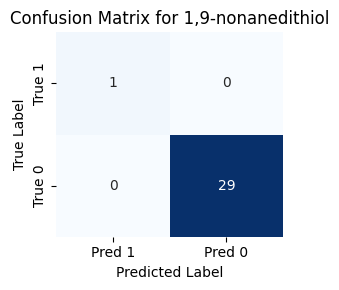

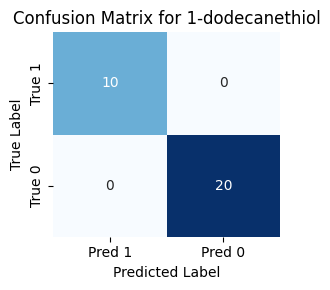

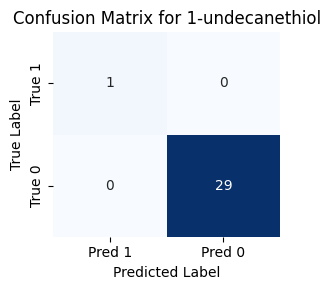

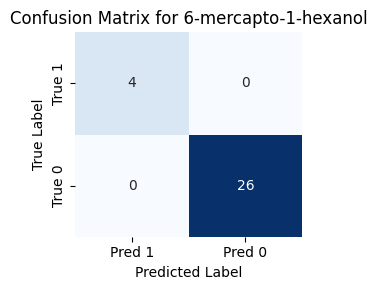

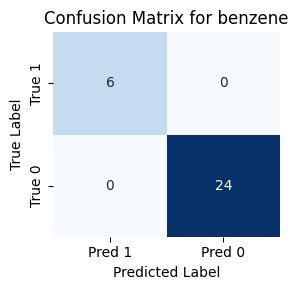

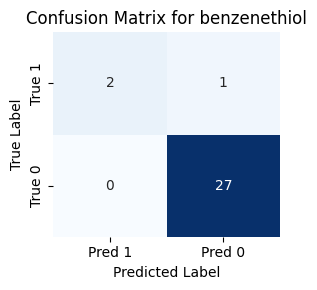

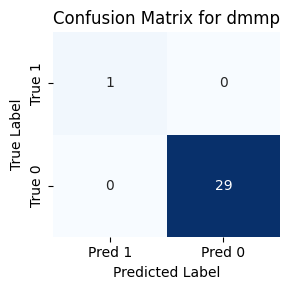

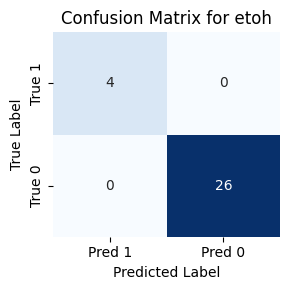

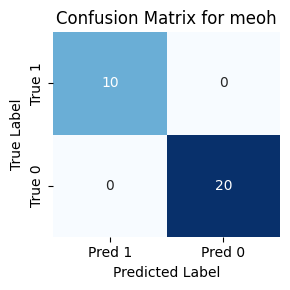

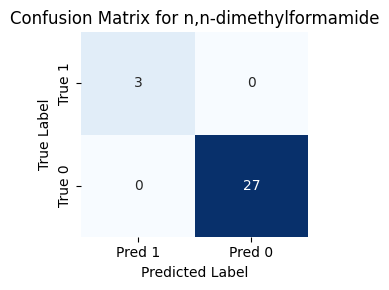

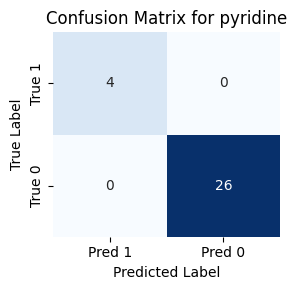

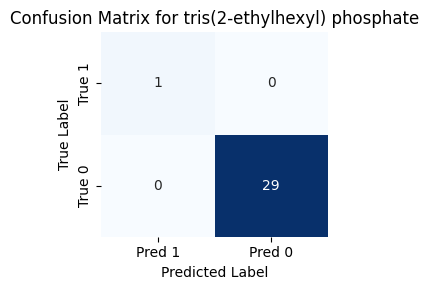

In [159]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate binary ground truth matrix (y_true) and predictions (y_pred)
y_true = np.array([[chem in [l1, l2] for chem in classes] for l1, l2 in zip(true1, true2)])
y_pred = binary_preds

# Compute multilabel confusion matrix
conf_matrices = multilabel_confusion_matrix(y_true, y_pred, labels=range(len(classes)))

# Plot each confusion matrix
for i, cm in enumerate(conf_matrices):
    tn, fp, fn, tp = cm.ravel()
    cm_display = np.array([[tp, fn], [fp, tn]])
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm_display, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 1", "Pred 0"], yticklabels=["True 1", "True 0"])
    plt.title(f"Confusion Matrix for {classes[i]}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


In [160]:
from tqdm import tqdm
# Define grid of hyperparameters
alphas = [1e-4, 1e-3, 1e-2, 1e-1]
l1_ratios = [0.2, 0.5, 0.8, 1.0]

best_score = 0
best_params = None

# Store all results
grid_results = []

print("Starting ElasticNet hyperparameter tuning...")

for alpha, l1_ratio in tqdm(itertools.product(alphas, l1_ratios), total=len(alphas)*len(l1_ratios)):
    # Step 1: Fit ElasticNet for each query spectrum
    weights = np.array([elastic_net_nnls(ref_matrix_cps.T, q, alpha=alpha, l1_ratio=l1_ratio) for q in X_query_cps])
    
    # Step 2: Train meta-models
    meta_models = {}
    for i, chem in enumerate(classes):
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(weights, y_multi[:, i])
        meta_models[chem] = clf

    # Step 3: Predict
    proba_preds = np.array([meta_models[c].predict([w])[0] for w in weights for c in classes])
    proba_preds = proba_preds.reshape(len(weights), len(classes))
    binary_preds = (proba_preds > 0.5).astype(int)
    predicted_labels = [[c for j, c in enumerate(classes) if row[j]] for row in binary_preds]

    # Step 4: Score
    temp_df = pd.DataFrame({"True1": true1, "True2": true2, "Predicted": predicted_labels})
    total_acc = compute_total_accuracy(temp_df)
    grid_results.append((alpha, l1_ratio, total_acc))

    # Update best
    if total_acc > best_score:
        best_score = total_acc
        best_params = (alpha, l1_ratio)

# Display results
print("\nBest ElasticNet Hyperparameters:")
print(f"Alpha = {best_params[0]}, L1 Ratio = {best_params[1]}")
print(f"Best Total Accuracy: {best_score:.4f}")

# Optional: print all
print("\nAll Grid Results:")
for a, l1, acc in grid_results:
    print(f"alpha={a:<6}  l1_ratio={l1:<4}  accuracy={acc:.4f}")


Starting ElasticNet hyperparameter tuning...


100%|██████████| 16/16 [01:09<00:00,  4.32s/it]


Best ElasticNet Hyperparameters:
Alpha = 0.0001, L1 Ratio = 0.2
Best Total Accuracy: 1.0000

All Grid Results:
alpha=0.0001  l1_ratio=0.2   accuracy=1.0000
alpha=0.0001  l1_ratio=0.5   accuracy=1.0000
alpha=0.0001  l1_ratio=0.8   accuracy=1.0000
alpha=0.0001  l1_ratio=1.0   accuracy=1.0000
alpha=0.001   l1_ratio=0.2   accuracy=0.9667
alpha=0.001   l1_ratio=0.5   accuracy=0.8333
alpha=0.001   l1_ratio=0.8   accuracy=0.8000
alpha=0.001   l1_ratio=1.0   accuracy=0.8000
alpha=0.01    l1_ratio=0.2   accuracy=0.7333
alpha=0.01    l1_ratio=0.5   accuracy=0.3333
alpha=0.01    l1_ratio=0.8   accuracy=0.0333
alpha=0.01    l1_ratio=1.0   accuracy=0.0333
alpha=0.1     l1_ratio=0.2   accuracy=0.0000
alpha=0.1     l1_ratio=0.5   accuracy=0.0000
alpha=0.1     l1_ratio=0.8   accuracy=0.0000
alpha=0.1     l1_ratio=1.0   accuracy=0.0000


In [161]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from scipy.optimize import nnls
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.linear_model import ElasticNet

# DATA LOADING AND PREPROCESSING

def load_data(ref_csv_path, query_csv_path):
    """
    Load reference and query data from CSV files.
    
    Args:
        ref_csv_path (str): Path to reference CSV file
        query_csv_path (str): Path to query CSV file
        
    Returns:
        tuple: (ref_df, query_df)
    """
    ref_df = pd.read_csv(ref_csv_path)
    query_df = pd.read_csv(query_csv_path)
    return ref_df, query_df


def filter_columns_by_wavenumber(df, crop_max=1700):
    """
    Filter dataframe columns based on wavenumber threshold.
    
    Args:
        df (pd.DataFrame): Input dataframe
        crop_max (int): Maximum wavenumber to include
        
    Returns:
        list: Valid column names
    """
    all_cols = df.columns.drop("Label")
    wavenumbers = pd.to_numeric(all_cols, errors="coerce")
    valid_cols = all_cols[wavenumbers < crop_max]
    return valid_cols


def baseline_AsLS(y, lam=1e4, p=0.01, niter=10):
    """
    Asymmetric Least Squares baseline correction.
    
    Args:
        y (np.ndarray): Input spectrum
        lam (float): Smoothness parameter
        p (float): Asymmetry parameter
        niter (int): Number of iterations
        
    Returns:
        np.ndarray: Baseline-corrected spectrum
    """
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b


def preprocess_spectra(spectra, lam=1e4, p=0.01, niter=10):
    """
    Apply baseline correction and normalization to spectral data.
    
    Args:
        spectra (np.ndarray): Input spectra array
        lam (float): Lambda parameter for AsLS
        p (float): Asymmetry parameter for AsLS
        niter (int): Number of iterations for AsLS
        
    Returns:
        np.ndarray: Preprocessed spectra
    """
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg = baseline_AsLS(spec, lam=lam, p=p, niter=niter)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        normed = corr / nrm if nrm else corr
        out[i] = np.abs(normed)
    return out


def extract_and_preprocess_data(ref_df, query_df, crop_max=1700):
    """
    Extract and preprocess spectral data from dataframes.
    
    Args:
        ref_df (pd.DataFrame): Reference dataframe
        query_df (pd.DataFrame): Query dataframe
        crop_max (int): Maximum wavenumber to include
        
    Returns:
        tuple: (X_ref, X_query, ref_labels, valid_cols)
    """
    valid_cols = filter_columns_by_wavenumber(ref_df, crop_max)
    
    ref_data = ref_df[valid_cols].values
    query_data = query_df[valid_cols].values
    ref_labels = ref_df["Label"].values
    
    X_ref = preprocess_spectra(ref_data)
    X_query = preprocess_spectra(query_data)
    
    return X_ref, X_query, ref_labels, valid_cols

# REFERENCE SPECTRA AND PEAK DETECTION

def build_reference_spectra(X_ref, ref_labels):
    """
    Build reference spectra dictionary from preprocessed data.
    
    Args:
        X_ref (np.ndarray): Preprocessed reference spectra
        ref_labels (np.ndarray): Reference labels
        
    Returns:
        tuple: (classes, ref_spectra_avg, ref_matrix)
    """
    classes = np.unique(ref_labels)
    ref_spectra_avg = {c: X_ref[ref_labels == c].mean(axis=0) for c in classes}
    ref_matrix = np.array([ref_spectra_avg[c] for c in classes])
    return classes, ref_spectra_avg, ref_matrix


def extract_CPs(spectra, num_peaks=15, height=0.01, prominence=0.01):
    """
    Extract characteristic peaks from spectral data.
    
    Args:
        spectra (np.ndarray): Input spectra
        num_peaks (int): Number of top peaks to extract
        height (float): Minimum peak height
        prominence (float): Minimum peak prominence
        
    Returns:
        list: Sorted list of characteristic peak indices
    """
    counts = np.zeros(spectra.shape[1])
    for spec in spectra:
        peaks, _ = find_peaks(spec, height=height, prominence=prominence)
        counts[peaks] += 1
    top_peaks = np.argsort(counts)[-num_peaks:]
    return sorted(top_peaks)

# NNLS via Elastic-Net regularization

def elastic_net_nnls(A, b, alpha=0.001, l1_ratio=0.2):
    """
    Solve a non-negative constrained ElasticNet regression problem.
    
    Args:
        A (np.ndarray): Reference matrix (features x components)
        b (np.ndarray): Query spectrum (features,)
        alpha (float): Regularization strength
        l1_ratio (float): ElasticNet mixing parameter (0 = Ridge, 1 = Lasso)
        
    Returns:
        np.ndarray: Non-negative coefficients
    """
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True, max_iter=10000)
    model.fit(A, b)
    return model.coef_


def unmixing(ref_matrix, X_query, cps):
    """
    Perform spectral deconvolution using ElasticNet with non-negative constraints.
    
    Args:
        ref_matrix (np.ndarray): Reference spectra matrix
        X_query (np.ndarray): Query spectra
        cps (list): Characteristic peak indices
        
    Returns:
        np.ndarray: Deconvolution weights
    """
    ref_matrix_cps = ref_matrix[:, cps]
    X_query_cps = X_query[:, cps]
    
    weights_l1 = np.array([
        elastic_net_nnls(ref_matrix_cps.T, q) 
        for q in X_query_cps
    ])
    
    return weights_l1

# META-MODEL TRAINING AND PREDICTION

def create_binary_targets(query_df, classes):
    """
    Create binary target matrix for meta-model training.
    
    Args:
        query_df (pd.DataFrame): Query dataframe with labels
        classes (np.ndarray): Array of chemical classes
        
    Returns:
        np.ndarray: Binary target matrix
    """
    y_multi = np.array([
        [label in (l1, l2) for label in classes]
        for l1, l2 in zip(query_df["Label 1"], query_df["Label 2"])
    ])
    return y_multi


def train_meta_models(weights_l1, y_multi, classes):
    """
    Train meta-classifier models for each chemical class.
    
    Args:
        weights_l1 (np.ndarray): Deconvolution weights
        y_multi (np.ndarray): Binary target matrix
        classes (np.ndarray): Array of chemical classes
        
    Returns:
        dict: Dictionary of trained meta-models
    """
    meta_models = {}
    for i, chem in enumerate(classes):
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(weights_l1, y_multi[:, i])
        meta_models[chem] = clf
    return meta_models


def make_predictions(weights_l1, meta_models, classes):
    """
    Make predictions using trained meta-models.
    
    Args:
        weights_l1 (np.ndarray): Deconvolution weights
        meta_models (dict): Dictionary of trained meta-models
        classes (np.ndarray): Array of chemical classes
        
    Returns:
        list: List of predicted labels for each query
    """
    # Use meta-models to predict presence probabilities
    proba_preds = np.array([
        meta_models[c].predict([w])[0] 
        for w in weights_l1 
        for c in classes
    ])
    proba_preds = proba_preds.reshape(len(weights_l1), len(classes))
    
    # Get binary predictions
    binary_preds = (proba_preds > 0.5).astype(int)
    predicted_labels = []
    
    for i, row in enumerate(binary_preds):
        if row.sum() == 0:
            top_idx = np.argmax(proba_preds[i])
            row[top_idx] = 1
        predicted_labels.append([classes[j] for j in range(len(classes)) if row[j]])
    
    return predicted_labels

# EVALUATION AND METRICS

def create_results_dataframe(query_df, predicted_labels):
    """
    Create results dataframe with true and predicted labels.
    
    Args:
        query_df (pd.DataFrame): Query dataframe
        predicted_labels (list): Predicted labels
        
    Returns:
        pd.DataFrame: Results dataframe
    """
    true1 = query_df["Label 1"].values
    true2 = query_df["Label 2"].values
    results_df = pd.DataFrame({
        "True1": true1, 
        "True2": true2, 
        "Predicted": predicted_labels
    })
    return results_df


def compute_total_accuracy(results_df):
    """
    Compute total accuracy across all predictions.
    
    Args:
        results_df (pd.DataFrame): Results dataframe
        
    Returns:
        float: Total accuracy
    """
    correct = 0
    total = len(results_df)
    
    for _, row in results_df.iterrows():
        true1 = row["True1"]
        true2 = row["True2"]
        predicted = row["Predicted"]
        
        if pd.isna(true2):
            if true1 in predicted and len(predicted) == 1:
                correct += 1
        else:
            if true1 in predicted and true2 in predicted and len(predicted) == 2:
                correct += 1
    
    return correct / total


def calculate_class_metrics(query_df, predicted_labels, classes):
    """
    Calculate performance metrics for each chemical class.
    
    Args:
        query_df (pd.DataFrame): Query dataframe
        predicted_labels (list): Predicted labels
        classes (np.ndarray): Array of chemical classes
        
    Returns:
        pd.DataFrame: Filtered metrics dataframe
    """
    true1 = query_df["Label 1"].values
    true2 = query_df["Label 2"].values
    
    # Create binary predictions matrix
    binary_preds = np.zeros((len(predicted_labels), len(classes)))
    for i, pred_list in enumerate(predicted_labels):
        for pred in pred_list:
            if pred in classes:
                j = np.where(classes == pred)[0][0]
                binary_preds[i, j] = 1
    
    metrics = {}
    for i, chem in enumerate(classes):
        y_true = [(chem in [l1, l2]) for l1, l2 in zip(true1, true2)]
        y_pred = binary_preds[:, i]
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        metrics[chem] = {"Accuracy": acc, "Precision": prec, "Recall": rec}
    
    metrics_df = pd.DataFrame.from_dict(metrics, orient="index")
    filtered_metrics_df = metrics_df[~((metrics_df["Precision"] == 0) & (metrics_df["Recall"] == 0))]
    
    return filtered_metrics_df

# MAIN PIPELINE FUNCTION

def run_spectral_analysis_pipeline(ref_csv_path, query_csv_path, crop_max=1700):
    """
    Execute the complete spectral analysis pipeline.
    
    Args:
        ref_csv_path (str): Path to reference CSV file
        query_csv_path (str): Path to query CSV file
        crop_max (int): Maximum wavenumber to include
        
    Returns:
        tuple: (results_df, metrics_df, accuracy)
    """
    # Load and preprocess data
    ref_df, query_df = load_data(ref_csv_path, query_csv_path)
    X_ref, X_query, ref_labels, valid_cols = extract_and_preprocess_data(ref_df, query_df, crop_max)
    
    # Build reference spectra and extract characteristic peaks
    classes, ref_spectra_avg, ref_matrix = build_reference_spectra(X_ref, ref_labels)
    cps = extract_CPs(X_ref, num_peaks=15)
    
    # Perform deconvolution
    weights_l1 = unmixing(ref_matrix, X_query, cps)
    
    # Train meta-models
    y_multi = create_binary_targets(query_df, classes)
    meta_models = train_meta_models(weights_l1, y_multi, classes)
    
    # Make predictions
    predicted_labels = make_predictions(weights_l1, meta_models, classes)
    
    # Evaluate results
    results_df = create_results_dataframe(query_df, predicted_labels)
    metrics_df = calculate_class_metrics(query_df, predicted_labels, classes)
    accuracy = compute_total_accuracy(results_df)
    
    return results_df, metrics_df, accuracy

if __name__ == "__main__":
    results_df, metrics_df, accuracy = run_spectral_analysis_pipeline(ref_csv_path="reference_v2.csv", query_csv_path="query_v2.csv")

    print("Filtered Metrics:")
    print(metrics_df)
    print(f"\nTotal Accuracy: {accuracy:.4f}")

Filtered Metrics:
                              Accuracy  Precision    Recall
1,9-nonanedithiol             1.000000        1.0  1.000000
1-dodecanethiol               1.000000        1.0  1.000000
1-undecanethiol               1.000000        1.0  1.000000
6-mercapto-1-hexanol          1.000000        1.0  1.000000
benzene                       1.000000        1.0  1.000000
benzenethiol                  0.966667        1.0  0.666667
dmmp                          1.000000        1.0  1.000000
etoh                          1.000000        1.0  1.000000
meoh                          1.000000        1.0  1.000000
n,n-dimethylformamide         1.000000        1.0  1.000000
pyridine                      1.000000        1.0  1.000000
tris(2-ethylhexyl) phosphate  1.000000        1.0  1.000000

Total Accuracy: 0.9667
